# Transfer Learning CIFAR10

* Train a simple convnet on the CIFAR dataset the first 5 output classes [0..4].
* Freeze convolutional layers and fine-tune dense layers for the last 5 ouput classes [5..9].


### 1. Import CIFAR10 data and create 2 datasets with one dataset having classes from 0 to 4 and other having classes from 5 to 9 

Data Description:
The CIFAR-10 data consists of 60,000 32x32 color images in 10 classes, with 6000 images per class. There are 50,000 training images and 10,000 test images. 

The label classes in the dataset are:

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

The classes are completely mutually exclusive. 


In [1]:
import warnings 
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.losses import categorical_crossentropy
from keras.models import Model
from keras.models import load_model

from keras.callbacks import TensorBoard
import time

from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
#np.random.seed(2017) 

In [3]:
# Loading CIFAR10 dataset
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
num_train, img_rows, img_cols, img_channels =  X_train.shape
num_test, _, _, _ =  X_test.shape
num_classes = len(np.unique(y_train))
print("Train dataset shape: ", X_train.shape)
print("Test dataset shape: ", X_test.shape)
print("Number of classes: ", num_classes)

Train dataset shape:  (50000, 32, 32, 3)
Test dataset shape:  (10000, 32, 32, 3)
Number of classes:  10


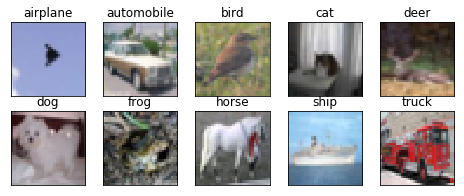

In [5]:
# quick look on each classes
class_names = ['airplane','automobile','bird','cat','deer', 'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = X_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = np.transpose(features_idx[img_num, ::], (0, 1, 2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

### 2. Use One-hot encoding to divide y_train and y_test into required no of output classes

In [6]:
print("Size of y_train: ", y_train.shape)
print("Size of y_test: ", y_test.shape)

Size of y_train:  (50000, 1)
Size of y_test:  (10000, 1)


In [7]:
# Flatten a 2d numpy array into 1d array
y_train_r = y_train.ravel()
y_test_r = y_test.ravel()

print("Size of y_train: ", y_train_r.shape)
print("Size of y_test: ", y_test_r.shape)
print('First 5 examples are: ', y_train_r[0:5])

Size of y_train:  (50000,)
Size of y_test:  (10000,)
First 5 examples are:  [6 9 9 4 1]


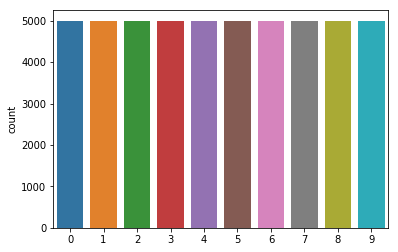

In [8]:
# view num of classes
num_classes = len(np.unique(y_train_r))

#plotting how the classes are distributed
sns.countplot(y_train_r)

In [9]:
# normalize inputs from 0-255 to 0-1
X_train_std = X_train.astype('float32')/255
X_test_std = X_test.astype('float32')/255

In [10]:
# dataset have 10 classes and each label is an integer between 0 to 9
y_train_cat = keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_cat = keras.utils.to_categorical(y_test, num_classes=num_classes)

In [11]:
print(y_train_cat.shape)
print('First 5 examples are: ', y_train_cat[0:5])

(50000, 10)
First 5 examples are:  [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


### 3. Build a sequential neural network model which can classify the classes 0 to 4 of CIFAR10 dataset with at least 80% accuracy on test data

In [12]:
# utility fxn to get dataset for specific classes set
def prepare_dataset_class0to4(X_train, y_train, X_test, y_test):
    idx = np.where(y_train[:]<=4)[0]
    X_train_new = X_train[idx,::]
    y_train_new = y_train[idx,::]

    idx = np.where(y_test[:]<=4)[0]
    X_test_new = X_test[idx,::]
    y_test_new = y_test[idx,::]
    return X_train_new, y_train_new, X_test_new, y_test_new
    
def prepare_dataset_class5to9(X_train, y_train, X_test, y_test):
    idx = np.where(y_train[:]>=5)[0]
    X_train_new = X_train[idx,::]
    y_train_new = y_train[idx,::]

    idx = np.where(y_test[:]>=5)[0]
    X_test_new = X_test[idx,::]
    y_test_new = y_test[idx,::]
    return X_train_new, y_train_new, X_test_new, y_test_new

def plot_samples(classname, classcodes, X_train, y_train):
    fig = plt.figure(figsize=(8,3))
    for i in range(5):
        ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
        idx = np.where(y_train[:]==classcodes[i])[0]
        features_idx = X_train[idx,::]
        img_num = np.random.randint(features_idx.shape[0])
        im = np.transpose(features_idx[img_num, ::], (0, 1, 2))
        ax.set_title(classname[i])
        plt.imshow(im)
    plt.show()

X_train shape:  (25000, 32, 32, 3)
y_train shape:  (25000, 1)
X_test shape:  (5000, 32, 32, 3)
y_test shape:  (5000, 1)
Number of classes:  5
First 5 examples are:  [[4]
 [1]
 [1]
 [2]
 [3]]


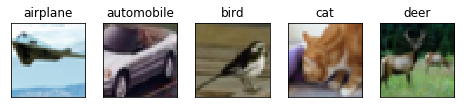

In [13]:
# get dataset containing only classes 0 to 4
X_train_0to4, y_train_0to4, X_test_0to4, y_test_0to4 = prepare_dataset_class0to4(X_train, y_train, X_test, y_test)

num_train_0to4, img_rows_0to4, img_cols_0to4, img_channels_0to4 =  X_train_0to4.shape
input_shape_0to4 = (img_rows_0to4, img_cols_0to4, img_channels_0to4)
num_classes_0to4 = len(np.unique(y_train_0to4))
print("X_train shape: ", X_train_0to4.shape)
print("y_train shape: ", y_train_0to4.shape)
print("X_test shape: ", X_test_0to4.shape)
print("y_test shape: ", y_test_0to4.shape)
print("Number of classes: ", num_classes_0to4)

# class 0 to 4 samples
print('First 5 examples are: ', y_train_0to4[0:5])

# classes 0 to 4
class_names_0to4 = ['airplane','automobile','bird','cat','deer']
class_0to4 = [0 ,1 ,2 ,3 , 4]
              
plot_samples(class_names_0to4, class_0to4, X_train_0to4, y_train_0to4)

In [14]:
# Flatten a 2d numpy array into 1d array
y_train_0to4 = y_train_0to4.ravel()
y_test_0to4 = y_test_0to4.ravel()

# normalize inputs from 0-255 to 0-1
X_train_0to4_std = X_train_0to4.astype('float32')/255
X_test_0to4_std = X_test_0to4.astype('float32')/255

# this dataset have 5 classes and each label is an integer between 0 to 4
y_train_0to4_cat = keras.utils.to_categorical(y_train_0to4, num_classes=num_classes_0to4)
y_test_0to4_cat = keras.utils.to_categorical(y_test_0to4, num_classes=num_classes_0to4)

print(y_train_0to4_cat.shape)
print('First 5 examples are: ', y_train_0to4_cat[0:5])

(25000, 5)
First 5 examples are:  [[0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


X_train shape:  (25000, 32, 32, 3)
y_train shape:  (25000, 1)
X_test shape:  (5000, 32, 32, 3)
y_test shape:  (5000, 1)
Number of classes:  5
First 5 examples are:  [[6]
 [9]
 [9]
 [7]
 [8]]


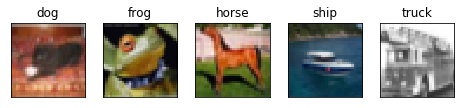

In [15]:
# get dataset containing only classes 5 to 9
X_train_5to9, y_train_5to9, X_test_5to9, y_test_5to9 = prepare_dataset_class5to9(X_train, y_train, X_test, y_test)

num_train_5to9, img_rows_5to9, img_cols_5to9, img_channels_5to9 =  X_train_5to9.shape
input_shape_5to9 = (img_rows_5to9, img_cols_5to9, img_channels_5to9)
num_classes_5to9 = len(np.unique(y_train_5to9))
print("X_train shape: ", X_train_5to9.shape)
print("y_train shape: ", y_train_5to9.shape)
print("X_test shape: ", X_test_5to9.shape)
print("y_test shape: ", y_test_5to9.shape)
print("Number of classes: ", num_classes_5to9)

# class 5 to 9 samples
print('First 5 examples are: ', y_train_5to9[0:5])

# classes 5 to 9
class_names_5to9 = ['dog','frog','horse','ship','truck']
class_5to9 = [5, 6, 7, 8, 9]
              
plot_samples(class_names_5to9, class_5to9, X_train_5to9, y_train_5to9)

In [16]:
# Flatten a 2d numpy array into 1d array
y_train_5to9 = y_train_5to9.ravel()
y_test_5to9 = y_test_5to9.ravel()

# here label value is between 5 to 9 to adjust it between 0 to 4 for categorical processing
y_train_5to9_align = y_train_5to9 - 5
y_test_5to9_align = y_test_5to9 - 5

# normalize inputs from 0-255 to 0-1
X_train_5to9_std = X_train_5to9.astype('float32')/255
X_test_5to9_std = X_test_5to9.astype('float32')/255

# this dataset have 5 classes and each label is an integer between 0 to 4(pls note class code were offeted by 5)
y_train_5to9_cat = keras.utils.to_categorical(y_train_5to9_align, num_classes=num_classes_5to9)
y_test_5to9_cat = keras.utils.to_categorical(y_test_5to9_align, num_classes=num_classes_5to9)

print(y_train_5to9_cat.shape)
print('First 5 examples are: ', y_train_5to9_cat[0:5])

(25000, 5)
First 5 examples are:  [[0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]


In [17]:
# utility fxn to plot model history and accuracy for each epoch
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [18]:
# get accuracy for test data
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [19]:
# Define the model
model = Sequential()

# padding = 'same' return the output having same dimension as inout image
model.add(Conv2D(48, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_shape_0to4, name='layer1_conv1'))
model.add(Conv2D(48, kernel_size=(3, 3), activation='relu', name='layer1_conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='layer1_pool'))
model.add(Dropout(rate=0.25, name='layer1_dropout'))

model.add(Conv2D(96, kernel_size=(3, 3), padding='same', activation='relu', name='layer2_conv1'))
model.add(Conv2D(96, kernel_size=(3, 3), activation='relu', name='layer2_conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='layer2_pool'))
model.add(Dropout(rate=0.25, name='layer2_dropout'))


model.add(Conv2D(192, kernel_size=(3, 3), padding='same', activation='relu', name='layer3_conv1'))
model.add(Conv2D(192, kernel_size=(3, 3), activation='relu', name='layer3_conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='layer3_pool'))
model.add(Dropout(rate=0.25, name='layer3_dropout'))

#Flatten the layer
model.add(Flatten(name='flatten'))

model.add(Dense(512, activation='relu', name='fc1'))
model.add(Dropout(rate=0.5, name='fc1_dropout'))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dropout(rate=0.5, name='fc2_dropout'))

# output layer 5 classes (class 0 to 4)
model.add(Dense(num_classes_0to4, activation='softmax', name='cifar_classes'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [21]:
# review the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_conv1 (Conv2D)        (None, 32, 32, 48)        1344      
_________________________________________________________________
layer1_conv2 (Conv2D)        (None, 30, 30, 48)        20784     
_________________________________________________________________
layer1_pool (MaxPooling2D)   (None, 15, 15, 48)        0         
_________________________________________________________________
layer1_dropout (Dropout)     (None, 15, 15, 48)        0         
_________________________________________________________________
layer2_conv1 (Conv2D)        (None, 15, 15, 96)        41568     
_________________________________________________________________
layer2_conv2 (Conv2D)        (None, 13, 13, 96)        83040     
_________________________________________________________________
layer2_pool (MaxPooling2D)   (None, 6, 6, 96)          0         
__________

***Initializing Early stopping and Model chekpoint callbacks***

In [23]:
# use tensorboard callback which will passed in model.fit function.
#Setting the directory to store the logs.
tensorboard = TensorBoard(log_dir=".logs/{}".format(time.time()))

#Adding Early stopping callback to the fit function is going to stop the training,
#if the val_loss is not going to change even '0.001' for more than 10 continous epochs

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)

#Adding Model Checkpoint callback to the fit function is going to save the weights whenever val_loss achieves 
# a new low value. Hence saving the best weights occurred during training

model_checkpoint =  ModelCheckpoint('cnn_checkpoint_{epoch:02d}_loss{val_loss:.4f}.h5',
                                                           monitor='val_loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1)

In [24]:
# Train the model
start = time.time()

history = model.fit(X_train_0to4_std, y_train_0to4_cat, # feature and target vector
          validation_data=(X_test_0to4_std, y_test_0to4_cat), # data for evaluation
          epochs=50, #200
          batch_size=128, # Number of observations per batch
          verbose=1,     # Print description after each epoch
          callbacks=[tensorboard,early_stopping,model_checkpoint])

end = time.time()
execution_dur = end - start;

Instructions for updating:
Use tf.cast instead.
Train on 25000 samples, validate on 5000 samples
Epoch 1/50
25000/25000 [==============================] - 3650s 146ms/step - loss: 1.2926 - acc: 0.4147 - val_loss: 1.0788 - val_acc: 0.5524

Epoch 00001: val_loss improved from inf to 1.07881, saving model to cnn_checkpoint_01_loss1.0788.h5
Epoch 2/50
25000/25000 [==============================] - 123s 5ms/step - loss: 0.9741 - acc: 0.5920 - val_loss: 0.8748 - val_acc: 0.6334

Epoch 00002: val_loss improved from 1.07881 to 0.87475, saving model to cnn_checkpoint_02_loss0.8748.h5
Epoch 3/50
25000/25000 [==============================] - 121s 5ms/step - loss: 0.8353 - acc: 0.6743 - val_loss: 0.7167 - val_acc: 0.7214

Epoch 00003: val_loss improved from 0.87475 to 0.71673, saving model to cnn_checkpoint_03_loss0.7167.h5
Epoch 4/50
25000/25000 [==============================] - 121s 5ms/step - loss: 0.7102 - acc: 0.7287 - val_loss: 0.6399 - val_acc: 0.7536

Epoch 00004: val_loss improved from 

In [25]:
print("Model execution time: %0.2f minutes" %(execution_dur/60))

Model execution time: 107.64 minutes


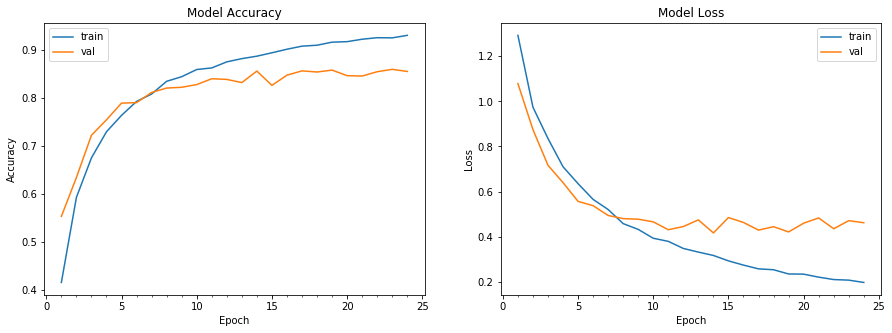

5000/5000 [==============================] - 11s 2ms/step

Test accuracy[Class0~4]: 85.44


In [26]:
# plot model history
plot_model_history(history)

# compute test accuracy
test_loss, test_acc = model.evaluate(X_test_0to4_std, y_test_0to4_cat)
print('\nTest accuracy[Class0~4]: %0.2f' %(test_acc*100))

In [27]:
# Save model and weights for future use. 
model.save('models/cifar10_class0to4_model.h5')
model.save_weights('models/cifar10_class0to4_weights.h5')

### 4. In the model which was built above (for classification of classes 0-4 in CIFAR10), make only the dense layers to be trainable and conv layers to be non-trainable

In [28]:
# utility fxn to build bottleneck model. it fetch layer upto where user need pretrained model
def build_bottleneck_model(model, layer_name):
    output = model.get_layer(layer_name).output
    bottleneck_model = Model(model.input, output)
    bottleneck_model.set_weights(model.get_weights())
    return bottleneck_model

# set pre-trained layer to non-trainable (weights will not be updated)
def set_conv_layer_as_non_trainable(model):
    for layer in model.layers:
        layer.trainable=False
        print("Layer: %s set to non-trainable" %(layer.name))
    return;

In [29]:
# load previous trained model for classes 0 to 4
pretrained_model = load_model('models/cifar10_class0to4_model.h5')

# initialize the model using pre-trained model and set their weights
model1 = Model(pretrained_model.input, pretrained_model.output)    
model1.set_weights(pretrained_model.get_weights())

# set convolution layer to non-trainable (weights will not be updated)
for layer in model1.layers[:14]:
    layer.trainable=False
    print("Layer: %s set to non-trainable" %(layer.name))


Layer: layer1_conv1_input set to non-trainable
Layer: layer1_conv1 set to non-trainable
Layer: layer1_conv2 set to non-trainable
Layer: layer1_pool set to non-trainable
Layer: layer1_dropout set to non-trainable
Layer: layer2_conv1 set to non-trainable
Layer: layer2_conv2 set to non-trainable
Layer: layer2_pool set to non-trainable
Layer: layer2_dropout set to non-trainable
Layer: layer3_conv1 set to non-trainable
Layer: layer3_conv2 set to non-trainable
Layer: layer3_pool set to non-trainable
Layer: layer3_dropout set to non-trainable
Layer: flatten set to non-trainable


In [30]:
# Compile the model
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_conv1_input (InputLay (None, 32, 32, 3)         0         
_________________________________________________________________
layer1_conv1 (Conv2D)        (None, 32, 32, 48)        1344      
_________________________________________________________________
layer1_conv2 (Conv2D)        (None, 30, 30, 48)        20784     
_________________________________________________________________
layer1_pool (MaxPooling2D)   (None, 15, 15, 48)        0         
_________________________________________________________________
layer1_dropout (Dropout)     (None, 15, 15, 48)        0         
_________________________________________________________________
layer2_conv1 (Conv2D)        (None, 15, 15, 96)        41568     
_________________________________________________________________
layer2_conv2 (Conv2D)        (None, 13, 13, 96)        83040     
__________

In [32]:
# Train the model
start = time.time()

history = model1.fit(X_train_0to4_std, y_train_0to4_cat, # feature and target vector
          validation_data=(X_test_0to4_std, y_test_0to4_cat), # data for evaluation
          epochs=50,
          batch_size=128, # Number of observations per batch
          verbose=1,     # Print description after each epoch
          callbacks=[tensorboard,early_stopping,model_checkpoint])

end = time.time()
execution_dur = end - start;

Train on 25000 samples, validate on 5000 samples
Epoch 1/50
25000/25000 [==============================] - 67s 3ms/step - loss: 0.1539 - acc: 0.9464 - val_loss: 0.5154 - val_acc: 0.8602

Epoch 00001: val_loss did not improve from 0.41702
Epoch 2/50
25000/25000 [==============================] - 66s 3ms/step - loss: 0.1513 - acc: 0.9461 - val_loss: 0.4937 - val_acc: 0.8630

Epoch 00002: val_loss did not improve from 0.41702
Epoch 3/50
25000/25000 [==============================] - 66s 3ms/step - loss: 0.1420 - acc: 0.9482 - val_loss: 0.5066 - val_acc: 0.8626

Epoch 00003: val_loss did not improve from 0.41702
Epoch 4/50
25000/25000 [==============================] - 66s 3ms/step - loss: 0.1420 - acc: 0.9495 - val_loss: 0.4803 - val_acc: 0.8626

Epoch 00004: val_loss did not improve from 0.41702
Epoch 5/50
25000/25000 [==============================] - 66s 3ms/step - loss: 0.1398 - acc: 0.9510 - val_loss: 0.5177 - val_acc: 0.8626

Epoch 00005: val_loss did not improve from 0.41702
Epoch 

In [33]:
print("Model execution time without training conv layer: %0.2f minutes" %(execution_dur/60))

Model execution time without training conv layer: 15.53 minutes


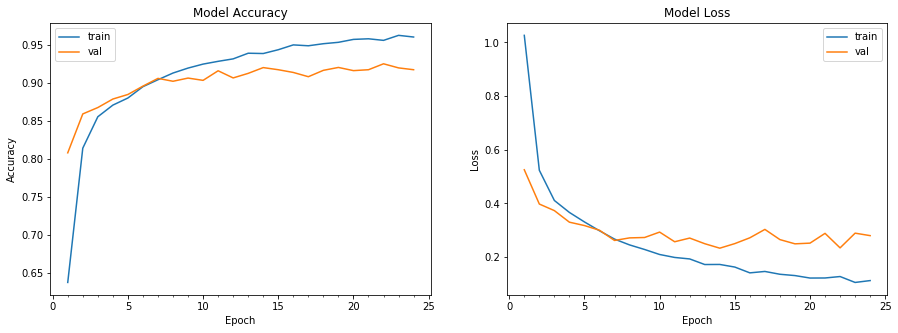

5000/5000 [==============================] - 16s 3ms/step

Test accuracy[Class0~4]: 86.14


In [43]:

# plot model history
plot_model_history(history)

# compute test accuracy
test_loss, test_acc = model1.evaluate(X_test_0to4_std, y_test_0to4_cat)
print('\nTest accuracy[Class0~4]: %0.2f' %(test_acc*100))

### 5. Utilize the the model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10  (Use Transfer Learning) <br>
Achieve an accuracy of more than 85% on test data

In [35]:
# load previous trained model for classes 0 to 4
pretrained_model = load_model('models/cifar10_class0to4_model.h5')

In [36]:
# initialize the model using pre-trained model and set their weights
model2 = Model(pretrained_model.input, pretrained_model.output)
model2.set_weights(pretrained_model.get_weights())

In [37]:
# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# review the model
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1_conv1_input (InputLay (None, 32, 32, 3)         0         
_________________________________________________________________
layer1_conv1 (Conv2D)        (None, 32, 32, 48)        1344      
_________________________________________________________________
layer1_conv2 (Conv2D)        (None, 30, 30, 48)        20784     
_________________________________________________________________
layer1_pool (MaxPooling2D)   (None, 15, 15, 48)        0         
_________________________________________________________________
layer1_dropout (Dropout)     (None, 15, 15, 48)        0         
_________________________________________________________________
layer2_conv1 (Conv2D)        (None, 15, 15, 96)        41568     
_________________________________________________________________
layer2_conv2 (Conv2D)        (None, 13, 13, 96)        83040     
__________

In [38]:
# Utilizing pretrained model on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10
start = time.time()

history = model2.fit(X_train_5to9_std, y_train_5to9_cat, # feature and target vector
          validation_data=(X_test_5to9_std, y_test_5to9_cat), # data for evaluation
          epochs=50,
          batch_size=128, # Number of observations per batch
          verbose=1,     # Print description after each epoch
          callbacks=[tensorboard,early_stopping,model_checkpoint])

end = time.time()
execution_dur = end - start;

Train on 25000 samples, validate on 5000 samples
Epoch 1/50
25000/25000 [==============================] - 167s 7ms/step - loss: 1.0263 - acc: 0.6374 - val_loss: 0.5253 - val_acc: 0.8080

Epoch 00001: val_loss did not improve from 0.41702
Epoch 2/50
25000/25000 [==============================] - 200s 8ms/step - loss: 0.5234 - acc: 0.8141 - val_loss: 0.3975 - val_acc: 0.8592

Epoch 00002: val_loss improved from 0.41702 to 0.39754, saving model to cnn_checkpoint_02_loss0.3975.h5
Epoch 3/50
25000/25000 [==============================] - 198s 8ms/step - loss: 0.4108 - acc: 0.8555 - val_loss: 0.3730 - val_acc: 0.8676

Epoch 00003: val_loss improved from 0.39754 to 0.37303, saving model to cnn_checkpoint_03_loss0.3730.h5
Epoch 4/50
25000/25000 [==============================] - 199s 8ms/step - loss: 0.3662 - acc: 0.8708 - val_loss: 0.3299 - val_acc: 0.8788

Epoch 00004: val_loss improved from 0.37303 to 0.32990, saving model to cnn_checkpoint_04_loss0.3299.h5
Epoch 5/50
25000/25000 [========

In [39]:
print("Model execution time: %0.2f minutes" %(execution_dur/60))

Model execution time: 79.41 minutes


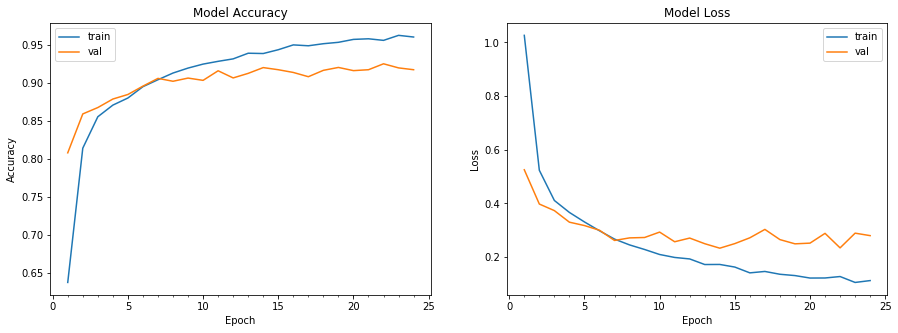

5000/5000 [==============================] - 16s 3ms/step

Test accuracy[Class0~4]: 91.74


In [42]:
# plot model history
plot_model_history(history)

# compute test accuracy
test_loss, test_acc = model2.evaluate(X_test_5to9_std, y_test_5to9_cat)
print('\nTest accuracy[Class0~4]: %0.2f' %(test_acc*100))

### Experiment Analysis Report

**Experiment-1:**: neural network model is built to classify the classes 0 to 4 of CIFAR10 dataset
**Result:**
1. First Epoch: val_loss: 1.0788 - val_acc: 0.55
2. Went upto 24 Epochs beyond which validation loss does not improve further by 0.001 difference
3. Model execution time: 107.64 minutes: as it trained all the layer and update weight for each iterations
4. Test accuracy[Class0~4]: 85.44%

**Experiment-2:**: Using above built model (for classification of classes 0-4 in CIFAR10), used only the dense layers as trainable and conv layers as non-trainable
1. First Epoc: val_loss: 0.5154 - val_acc: 0.8602. as we can see at first epoc only model learn well because of using previous learned weight.
2. Went upto 14 Epochs beyond which validation loss does not improve further by 0.001 difference
3. Model execution time 15.53 minutes. model took less time for learning and able to acheive little better accuracy. this is due to using previously trained weight and making concolution layer non-trainable.
4. Test accuracy[Class0~4]: 86.14%


**Experiment-3:**:Utilize the above model trained on CIFAR 10 (classes 0 to 4) to classify the classes 5 to 9 of CIFAR 10 (Use Transfer Learning) 
1. First epoch: val_loss: 0.5253 - val_acc: 0.8080. as we can see at first epoc only model learn well because of using previous learned weight (transfer learning).
2. Went upto 14 Epochs beyond which validation loss does not improve further by 0.001 difference
3. Model execution time: 79.41 minutes. model took lesser execution time than the previoud build model due to tranfer learning. 
4. Test accuracy[Class0~4]: 91.74%. with transfer learning and further traning the entire layer on new dataset, model able to aceive better accuracy above 91%.

# Text classification using TF-IDF

### 6. Load the dataset from sklearn.datasets

In [44]:
from sklearn.datasets import fetch_20newsgroups

In [45]:
categories = ['alt.atheism', 'soc.religion.christian', 'comp.graphics', 'sci.med']

### 7. Training data

In [48]:
twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)

### 8. Test data

In [49]:
twenty_test = fetch_20newsgroups(subset='test', categories=categories, shuffle=True, random_state=42)

###  a.  You can access the values for the target variable using .target attribute 
###  b. You can access the name of the class in the target variable with .target_names


In [50]:
twenty_train.target

array([1, 1, 3, ..., 2, 2, 2], dtype=int64)

In [51]:
twenty_train.target_names

['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']

In [54]:
twenty_train.data[0:5]

['From: sd345@city.ac.uk (Michael Collier)\nSubject: Converting images to HP LaserJet III?\nNntp-Posting-Host: hampton\nOrganization: The City University\nLines: 14\n\nDoes anyone know of a good way (standard PC application/PD utility) to\nconvert tif/img/tga files into LaserJet III format.  We would also like to\ndo the same, converting to HPGL (HP plotter) files.\n\nPlease email any response.\n\nIs this the correct group?\n\nThanks in advance.  Michael.\n-- \nMichael Collier (Programmer)                 The Computer Unit,\nEmail: M.P.Collier@uk.ac.city                The City University,\nTel: 071 477-8000 x3769                      London,\nFax: 071 477-8565                            EC1V 0HB.\n',
 "From: ani@ms.uky.edu (Aniruddha B. Deglurkar)\nSubject: help: Splitting a trimming region along a mesh \nOrganization: University Of Kentucky, Dept. of Math Sciences\nLines: 28\n\n\n\n\tHi,\n\n\tI have a problem, I hope some of the 'gurus' can help me solve.\n\n\tBackground of the probl

### 9.  Now with dependent and independent data available for both train and test datasets, using TfidfVectorizer fit and transform the training data and test data and get the tfidf features for both

In [125]:
from nltk.stem.snowball import SnowballStemmer
from sklearn import feature_extraction
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import re

In [126]:

stemmer = SnowballStemmer("english")

# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [127]:
# Training dataset and getting tfidf features
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=2000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,2))

%time train_tfidf_matrix = tfidf_vectorizer.fit_transform(twenty_train.data) #fit the vectorizer to train dataset

print(train_tfidf_matrix.shape)

C:\Users\birender.panwar\AppData\Local\conda\conda\envs\glbase\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Wall time: 35.9 s
(2257, 33)


In [142]:
# Training dataset: tfidf features
train_terms = tfidf_vectorizer.get_feature_names()
print("Features: \n", train_terms)

Features: 
 ["'m", "'s", 'ani', 'anyon', 'articl', 'becaus', 'believ', 'doe', 'god', 'good', 'just', 'know', 'like', 'line articl', 'look', 'make', 'mani', "n't", 'need', 'nntp-posting-host', 'onli', 'peopl', 'question', 'say', 'thing', 'think', 'time', 'univers', 'use', 'veri', 'way', 'whi', 'write']


In [129]:
# Test dataset and getting tfidf features
%time test_tfidf_matrix = tfidf_vectorizer.transform(twenty_test.data) #fit the vectorizer to test dataset

print(test_tfidf_matrix.shape)

Wall time: 25.6 s
(1502, 33)


In [143]:
# Test dataset: tfidf features
test_terms = tfidf_vectorizer.get_feature_names()
print("Features: \n",test_terms)

Features: 
 ["'m", "'s", 'ani', 'anyon', 'articl', 'becaus', 'believ', 'doe', 'god', 'good', 'just', 'know', 'like', 'line articl', 'look', 'make', 'mani', "n't", 'need', 'nntp-posting-host', 'onli', 'peopl', 'question', 'say', 'thing', 'think', 'time', 'univers', 'use', 'veri', 'way', 'whi', 'write']


### 10. Use logisticRegression with tfidf features as input and targets as output and train the model and report the train and test accuracy score

In [131]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [132]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(train_tfidf_matrix, twenty_train.target)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [133]:
acc_score = lr_model.score(train_tfidf_matrix, twenty_train.target) # get the accuracy score for train dataset
print("Train Accuracy Score: %0.2f" %(acc_score))

Train Accuracy Score: 0.61


In [134]:
acc_score = lr_model.score(test_tfidf_matrix, twenty_test.target) # get the accuracy score for test dataset
print("Test Accuracy Score: %0.2f" %(acc_score))

Train Accuracy Score: 0.53


In [141]:
# get precision and recall for all category using classification report
y_predict = lr_model.predict(test_tfidf_matrix)
cr = metrics.classification_report(twenty_test.target,y_predict)
print("Logistic Regression: Classification Report: \n\n", cr)

Logistic Regression: Classification Report: 

               precision    recall  f1-score   support

           0       0.54      0.34      0.42       319
           1       0.52      0.72      0.61       389
           2       0.42      0.38      0.40       396
           3       0.62      0.64      0.63       398

   micro avg       0.53      0.53      0.53      1502
   macro avg       0.53      0.52      0.51      1502
weighted avg       0.52      0.53      0.52      1502

